## Alg de Predição usando LightGBM e Logist Regression

Escolhas foram feitas devido a quantidade de dados e limitação de RAM e CPU:
- 1 milhão de linhas de dados para treino;
- 20% de toda a base para validação

In [88]:
import optuna
import polars as pl
import pandas as pd
import numpy as np
import lightgbm as lgb
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_recall_curve, roc_auc_score

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, cross_val_predict
from optuna.visualization import plot_param_importances, plot_optimization_history
from sklearn.impute import SimpleImputer

optuna.logging.set_verbosity(optuna.logging.WARNING)

In [89]:
df_raw = pl.read_parquet("./data/dengue.parquet")
df_validation = pl.read_parquet('./data/dengue_val.parquet')


### Limpando
- Retirando parametros que ou o enferemeiro não terá acesso no momento ou que são 100% vazamento de dados
- Pressuposto do modelo: o enfermeiro fara esses testes que foram mantidos ao atender o paciente na triagem ou serão já informados pelo paciente
- Limitante: UF foi retirado porque há desbalanceamento entre estados mais ricos e mais pobres na questão de cadastramento e qualidade dos dados

In [90]:
cols_gravidade = [col for col in df_raw.columns if col.startswith('BIN_GRAV_')]
cols_laboratorio = [
    'BIN_ALRM_PLAQ',  # Exame de Sangue
    'BIN_ALRM_HEMAT', # Exame de Sangue
    'BIN_LEUCOPENIA', # Exame de Sangue
    'BIN_ALRM_LIQ',   # USG/Exame físico complexo
    'SG_UF'
]

In [91]:
df_raw = df_raw.with_row_index("row_id")
df_raw = df_raw.drop(['DIAS_SINTOMA_INVESTIGACAO', 'DIAS_ALARME_INVESTIGACAO', 'DIAS_GRAVE_INVESTIGACAO'])
df_raw = df_raw.drop(cols_gravidade)
df_raw = df_raw.drop(cols_laboratorio)
df_validation = df_validation.drop(['DIAS_SINTOMA_INVESTIGACAO', 'DIAS_ALARME_INVESTIGACAO', 'DIAS_GRAVE_INVESTIGACAO'])
df_validation = df_validation.drop(cols_gravidade)
df_validation = df_validation.drop(cols_laboratorio)
train_mortes = df_raw.filter(pl.col("TARGET_OBITO") == 1)
n_mortos_train = train_mortes.height

n_vivos_necessarios = 1_000_000 - n_mortos_train
train_vivos = df_raw.filter(pl.col("TARGET_OBITO") == 0).sample(n=n_vivos_necessarios, seed=42)

# Juntar e embaralhar o treino
df_train_pl = pl.concat([train_mortes, train_vivos]).sample(fraction=1.0, seed=42)

In [92]:
print("Convertendo para Pandas...")
df_train = df_train_pl.drop("row_id").to_pandas()
df_val = df_validation.drop("row_id").to_pandas()

# Definição das Features
features_categoricas = ['CS_SEXO', 'FAIXA_ETARIA']
target = 'TARGET_OBITO'

# Pegar todas as colunas menos o target
features = [col for col in df_train.columns if col != target]

Convertendo para Pandas...


In [93]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 30 columns):
 #   Column          Non-Null Count    Dtype   
---  ------          --------------    -----   
 0   TARGET_OBITO    1000000 non-null  int32   
 1   IDADE_ANOS      999937 non-null   float64 
 2   FAIXA_ETARIA    999968 non-null   object  
 3   CS_SEXO         1000000 non-null  category
 4   IS_GESTANTE     1000000 non-null  int32   
 5   BIN_ALRM_HIPOT  1000000 non-null  int32   
 6   BIN_ALRM_VOM    1000000 non-null  int32   
 7   BIN_ALRM_SANG   1000000 non-null  int32   
 8   BIN_ALRM_ABDOM  1000000 non-null  int32   
 9   BIN_ALRM_LETAR  1000000 non-null  int32   
 10  BIN_ALRM_HEPAT  1000000 non-null  int32   
 11  BIN_DIABETES    1000000 non-null  int32   
 12  BIN_HEMATOLOG   1000000 non-null  int32   
 13  BIN_HEPATOPAT   1000000 non-null  int32   
 14  BIN_RENAL       1000000 non-null  int32   
 15  BIN_HIPERTENSA  1000000 non-null  int32   
 16  BIN_ACIDO_PEPT  100

In [94]:
del df_validation
del df_raw

In [95]:
for col in features_categoricas:
    df_train[col] = df_train[col].astype('category')
    df_val[col] = df_val[col].astype('category')

In [96]:
X = df_train[features]
y = df_train[target]

X_holdout = df_val[features]
y_holdout = df_val[target]

print(f"Treino (CV) shape: {X.shape}")
print(f"Holdout (Teste Final) shape: {X_holdout.shape}")

Treino (CV) shape: (1000000, 29)
Holdout (Teste Final) shape: (1950576, 29)


### Estudos do optuna para chegar nos melhores paramtros

In [97]:
def objective_lgbm(trial):
   
    param_grid = {
        'objective': 'binary',
        'metric': 'auc',
        'verbosity': -1,
        'boosting_type': 'gbdt',
        'n_jobs': -1,
        'seed': 42,
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 20, 256),
        'max_depth': trial.suggest_int('max_depth', 5, 30),
        'min_child_samples': trial.suggest_int('min_child_samples', 20, 1000),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 10.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 10.0, log=True),
        'scale_pos_weight': trial.suggest_float('scale_pos_weight', 1.0, 10.0) 
    }

   
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    aucs = []
    

    for train_idx, val_idx in cv.split(X, y):
        X_tr, y_tr = X.iloc[train_idx], y.iloc[train_idx]
        X_val, y_val = X.iloc[val_idx], y.iloc[val_idx]

        dtrain = lgb.Dataset(X_tr, label=y_tr, categorical_feature=features_categoricas)
        dval = lgb.Dataset(X_val, label=y_val, reference=dtrain, categorical_feature=features_categoricas)

        model = lgb.train(
            param_grid,
            dtrain,
            valid_sets=[dval],
            callbacks=[lgb.early_stopping(stopping_rounds=30, verbose=False)]
        )
        
        preds = model.predict(X_val, num_iteration=model.best_iteration)
        aucs.append(roc_auc_score(y_val, preds))
    
    mean_auc = np.mean(aucs)

    print(f"Trial {trial.number} finalizado. Média AUC: {mean_auc:.5f}")
    
    return mean_auc


def objective_lr(trial):
    solver = trial.suggest_categorical('solver', ['lbfgs', 'liblinear'])
    
    if solver == 'liblinear':
        penalty = trial.suggest_categorical('penalty', ['l1', 'l2'])
    else:
        penalty = 'l2'

    C = trial.suggest_float('C', 1e-4, 1e2, log=True)

    numeric_features = [col for col in X.columns if col not in features_categoricas]
    categorical_features = features_categoricas

    numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')), 
        ('scaler', StandardScaler())
    ])

    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')), 
        ('onehot', OneHotEncoder(handle_unknown='ignore', drop='first'))
    ])

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categorical_features)
        ])

    clf = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', LogisticRegression(
            C=C, 
            solver=solver, 
            penalty=penalty, 
            max_iter=1000, 
            random_state=42
        ))
    ])

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42) 
    
    scores = cross_val_score(clf, X, y, cv=cv, scoring='roc_auc', n_jobs=-1)
    s_m = scores.mean()
    print(f"Trial {trial.number} finalizado. Média AUC: {s_m:.5f}")

    return s_m

## Realizando os trials

In [ ]:
print(">>> Iniciando otimização do LightGBM...")
study_lgbm = optuna.create_study(direction='maximize', study_name="LGBM_Dengue")
study_lgbm.optimize(objective_lgbm, n_trials=25) 

print(f"\nMelhor AUC LightGBM: {study_lgbm.best_value:.5f}")
print("Melhores Params LGBM:", study_lgbm.best_params)


>>> Iniciando otimização do LightGBM...


In [ ]:
print("\n>>> Iniciando otimização da Regressão Logística...")
study_lr = optuna.create_study(direction='maximize', study_name="LogReg_Dengue")
study_lr.optimize(objective_lr, n_trials=25) 

print(f"\nMelhor AUC LogReg: {study_lr.best_value:.5f}")
print("Melhores Params LogReg:", study_lr.best_params)

print("\n" + "="*30)
print(f"Vencedor: {'LightGBM' if study_lgbm.best_value > study_lr.best_value else 'Logistic Regression'}")
print(f"Diferença de AUC: {abs(study_lgbm.best_value - study_lr.best_value):.5f}")
print("="*30)

## Importancia das variáves

In [ ]:
plot_param_importances(study_lgbm)

In [ ]:
best_params_lgbm = study_lgbm.best_params
best_params_lr = study_lr.best_params

print("Melhores parâmetros LightGBM:", best_params_lgbm)
print("Melhores parâmetros LogReg:", best_params_lr)

target_recall = 0.95

Melhores parâmetros LightGBM: {'learning_rate': 0.06217299572779416, 'num_leaves': 152, 'max_depth': 9, 'min_child_samples': 384, 'subsample': 0.9532346341677073, 'colsample_bytree': 0.6907754158242696, 'reg_alpha': 0.011956495377249968, 'reg_lambda': 8.857189058114317, 'scale_pos_weight': 1.3514069373240267}
Melhores parâmetros LogReg: {'solver': 'liblinear', 'penalty': 'l2', 'C': 0.01101902034846129}


## Função de avaliação do modelo final com plotagem de gráfico

In [ ]:
def avaliar_modelo(nome_modelo, y_train, y_oof_probs, y_holdout, y_proba_holdout, df_holdout_base):
    print(f"\n{'='*20} AVALIAÇÃO: {nome_modelo} {'='*20}")
    
    precisions, recalls, thresholds = precision_recall_curve(y_train, y_oof_probs)
    
    try:
        idx_low = np.where(recalls >= target_recall)[0][-1] 
        t_low = thresholds[idx_low]
    except IndexError:
        t_low = 0.01 
    
    f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-10)
    idx_high = np.argmax(f1_scores)
    t_high = thresholds[idx_high]
    
    if t_high <= t_low:
        t_high = t_low + 0.05
        
    print(f"   [Treino] T_LOW definido em:  {t_low:.5f} (Recall esperado ~{target_recall*100:.0f}%)")
    print(f"   [Treino] T_HIGH definido em: {t_high:.5f} (F1 Max esperado)")

    conditions = [
        (y_proba_holdout < t_low),
        (y_proba_holdout >= t_low) & (y_proba_holdout < t_high),
        (y_proba_holdout >= t_high)
    ]
    choices = ['1. Verde', '2. Amarelo', '3. Vermelho']
    
    df_result = df_holdout_base.copy()
    df_result['Risco'] = np.select(conditions, choices, default='Erro')

    resumo = pd.crosstab(df_result['Risco'], df_result[target].map({0: 'Vivos', 1: 'Óbitos'}))
    resumo = resumo.reindex(['1. Verde', '2. Amarelo', '3. Vermelho']).fillna(0)
    resumo['Total'] = resumo.sum(axis=1)
    resumo['%_dos_Obitos_Reais'] = (resumo['Óbitos'] / resumo['Óbitos'].sum()) * 100
    
    print(f"\n>>> PERFORMANCE REAL ({nome_modelo}) <<<")
    print(resumo)
    
    obitos_total = resumo['Óbitos'].sum()
    obitos_pegos = resumo.loc[['2. Amarelo', '3. Vermelho'], 'Óbitos'].sum()
    recall_real = obitos_pegos / obitos_total if obitos_total > 0 else 0

    print(f"\nRecall Real Atingido: {recall_real:.2%}")
    if recall_real < target_recall:
        print(f"Nota: O Recall caiu ({target_recall*100}% -> {recall_real*100:.2f}%). Considere baixar T_LOW.")
    else:
        print("Sucesso: A generalização das zonas de risco funcionou.")

    plt.figure(figsize=(10, 5))
    sns.kdeplot(y_proba_holdout[y_holdout == 0], fill=True, color='blue', alpha=0.3, label='Holdout: Sobreviventes')
    sns.kdeplot(y_proba_holdout[y_holdout == 1], fill=True, color='red', alpha=0.3, label='Holdout: Óbitos')
    plt.axvline(t_low, color='green', linestyle='--', label=f'T_Low: {t_low:.3f}')
    plt.axvline(t_high, color='red', linestyle='--', label=f'T_High: {t_high:.3f}')
    plt.title(f'Distribuição de Probabilidades - {nome_modelo}')
    plt.legend(loc='upper right')
    plt.show()

## Melhor modelo LightGBM com hiperâmetros otimizados sendo rodados

>>> Processando LightGBM Final...
Treinando LightGBM em todo o dataset...

==================== AVALIAÇÃO: LightGBM Otimizado ====================
   [Treino] T_LOW definido em:  0.00338 (Recall esperado ~95%)
   [Treino] T_HIGH definido em: 0.31902 (F1 Max esperado)

>>> PERFORMANCE REAL (LightGBM Otimizado) <<<
TARGET_OBITO    Vivos  Óbitos    Total  %_dos_Obitos_Reais
Risco                                                     
1. Verde      1351034     101  1351135            4.023904
2. Amarelo     588365    1032   589397           41.115538
3. Vermelho      8667    1377    10044           54.860558

Recall Real Atingido: 95.98%
Sucesso: A generalização das zonas de risco funcionou.


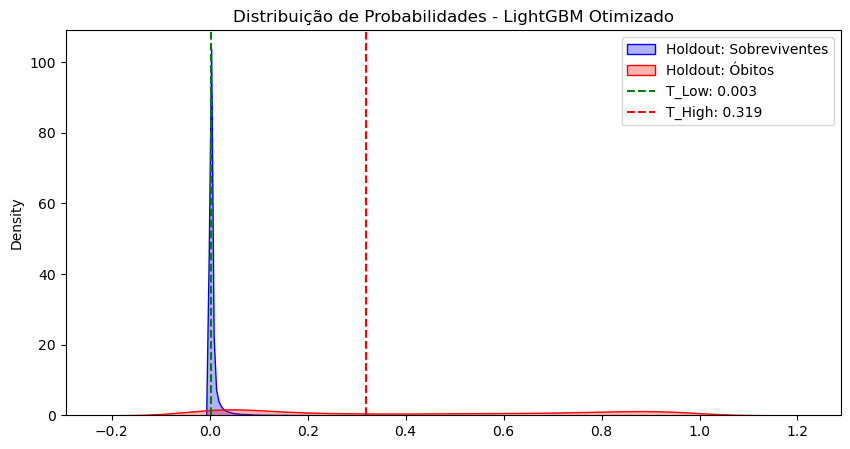

In [ ]:
print(">>> Processando LightGBM Final...")

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
y_oof_lgbm = np.zeros(len(X))

fixed_params = {
    'objective': 'binary',
    'metric': 'auc',
    'verbosity': -1,
    'boosting_type': 'gbdt',
    'seed': 42,
    'n_jobs': -1
}
final_params_lgbm = {**fixed_params, **best_params_lgbm}

for train_idx, val_idx in cv.split(X, y):
    X_tr, y_tr = X.iloc[train_idx], y.iloc[train_idx]
    X_val, y_val = X.iloc[val_idx], y.iloc[val_idx]
    
    dtrain = lgb.Dataset(X_tr, label=y_tr, categorical_feature=features_categoricas)
    dval = lgb.Dataset(X_val, label=y_val, reference=dtrain, categorical_feature=features_categoricas)
    
    model_cv = lgb.train(final_params_lgbm, dtrain, num_boost_round=1000, 
                         valid_sets=[dval], callbacks=[lgb.early_stopping(30, verbose=False)])
    
    y_oof_lgbm[val_idx] = model_cv.predict(X_val, num_iteration=model_cv.best_iteration)

print("Treinando LightGBM em todo o dataset...")
dtrain_full = lgb.Dataset(X, label=y, categorical_feature=features_categoricas)
final_model_lgbm = lgb.train(final_params_lgbm, dtrain_full, num_boost_round=1000)

y_proba_holdout_lgbm = final_model_lgbm.predict(X_holdout)

avaliar_modelo("LightGBM Otimizado", y, y_oof_lgbm, y_holdout, y_proba_holdout_lgbm, df_val)


## Melhor modelo Logistic Regression sendo rodado

>>> Processando Logistic Regression Final...
Gerando OOF predictions para LR (pode demorar um pouco)...


/home/aderson/miniconda3/envs/dengue/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1305: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 16.
  warnings.warn(
/home/aderson/miniconda3/envs/dengue/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1305: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 16.
  warnings.warn(
/home/aderson/miniconda3/envs/dengue/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1305: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 16.
  warnings.warn(


Treinando Logistic Regression em todo o dataset...


/home/aderson/miniconda3/envs/dengue/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1305: UserWarning:

'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 16.




==================== AVALIAÇÃO: Logistic Regression Otimizada ====================
   [Treino] T_LOW definido em:  0.00392 (Recall esperado ~95%)
   [Treino] T_HIGH definido em: 0.19771 (F1 Max esperado)

>>> PERFORMANCE REAL (Logistic Regression Otimizada) <<<
TARGET_OBITO    Vivos  Óbitos    Total  %_dos_Obitos_Reais
Risco                                                     
1. Verde      1277579     135  1277714            5.378486
2. Amarelo     661302    1174   662476           46.772908
3. Vermelho      9185    1201    10386           47.848606

Recall Real Atingido: 94.62%
Nota: O Recall caiu (95.0% -> 94.62%). Considere baixar T_LOW.


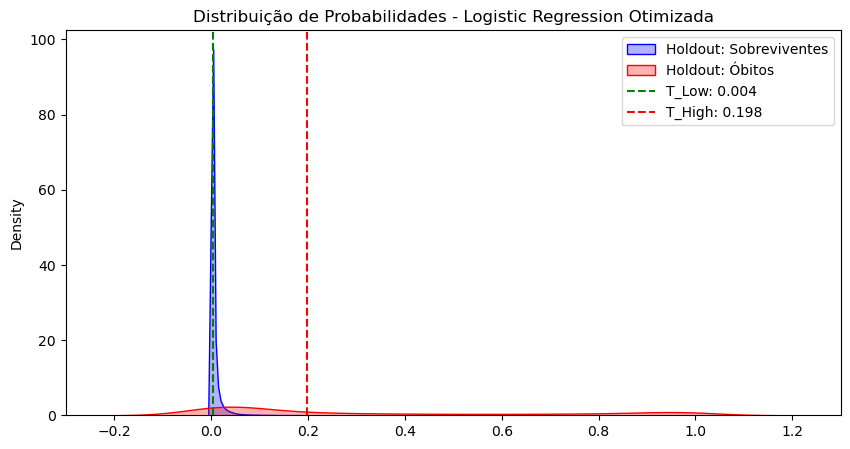

In [ ]:
print(">>> Processando Logistic Regression Final...")

numeric_features = [col for col in X.columns if col not in features_categoricas]
numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')), 
        ('scaler', StandardScaler())
    ])

    
categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')), 
        ('onehot', OneHotEncoder(handle_unknown='ignore', drop='first'))
    ])

   
preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, features_categoricas)
        ])

solver = best_params_lr['solver']
C = best_params_lr['C']
penalty = best_params_lr.get('penalty', 'l2') 

final_pipe_lr = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(
        C=C, 
        solver=solver, 
        penalty=penalty, 
        max_iter=1000, 
        random_state=42
    ))
])

print("Gerando OOF predictions para LR (pode demorar um pouco)...")
y_oof_lr = cross_val_predict(final_pipe_lr, X, y, cv=3, method='predict_proba', n_jobs=-1)[:, 1]

print("Treinando Logistic Regression em todo o dataset...")
final_pipe_lr.fit(X, y)

y_proba_holdout_lr = final_pipe_lr.predict_proba(X_holdout)[:, 1]

avaliar_modelo("Logistic Regression Otimizada", y, y_oof_lr, y_holdout, y_proba_holdout_lr, df_val)